<a href="https://www.kaggle.com/code/adends/neural-network-with-embeddings-for-house-prices?scriptVersionId=167899900" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.impute import KNNImputer
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

plt.style.use('fivethirtyeight')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Exploratory Data Analysis

In [2]:
df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


From this head snippet, we can see that we have some columns (Alley, PoolQC, MiscFeature) likely have a high number of missing values. We'll be sure to investigate those.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We can see that we have quite a few columns (1600, **81**). A lot of these are probably irrelevant so we need to filter those out for later results. Attempts with all of these columns usually results in a model with an NaN loss function, meaning no predictions can really be made. We can also see we have quite a few categorical features. Our stratedgy for these will be embedding layers.

In [5]:
df.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


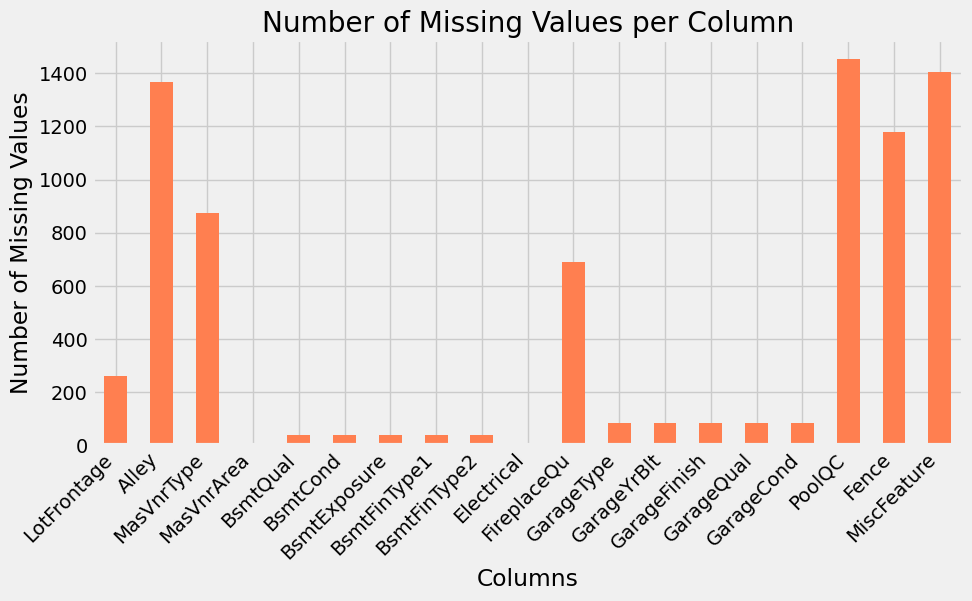

In [6]:
# Get all columns that contain missing values and plot with barplot
non_full_cols = df.isna().sum()
non_full_cols = non_full_cols[non_full_cols != 0]

fig, ax = plt.subplots(figsize=(10,5))
non_full_cols.plot(kind='bar', ax=ax, color='coral')

ax.set_title('Number of Missing Values per Column')
ax.set_xlabel('Columns')
ax.set_ylabel('Number of Missing Values')

plt.xticks(rotation=45, ha='right') 
plt.show()

Now we get a better look into the completeness of our dataset. We have a couple of extreme columns with nearly all missing values (Remember original dataset was 1600 entries). For these extremely incomplete rows we are going to remove them. For the gray area columns like `LotsFrontage` and `FirePlaceQu`, we will keep them for now.

In [7]:
# Identifying mostly complete columns (low_missing_cols) and splitting them into Categorical and Numerical
low_missing_cols = ['MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageType','GarageFinish', 'GarageYrBlt', 'GarageQual', 'GarageCond']
filtered_df = df[low_missing_cols]

numerical_missing_cols = filtered_df.select_dtypes(include='number').columns.tolist()
categorical_missing_cols = filtered_df.select_dtypes(include='object').columns.tolist()

In [8]:
# Ensure the selected categorical columns are indeed categorical
df[categorical_missing_cols]

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,Electrical,GarageType,GarageFinish,GarageQual,GarageCond
0,Gd,TA,No,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
1,Gd,TA,Gd,ALQ,Unf,SBrkr,Attchd,RFn,TA,TA
2,Gd,TA,Mn,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
3,TA,Gd,No,ALQ,Unf,SBrkr,Detchd,Unf,TA,TA
4,Gd,TA,Av,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
...,...,...,...,...,...,...,...,...,...,...
1455,Gd,TA,No,Unf,Unf,SBrkr,Attchd,RFn,TA,TA
1456,Gd,TA,No,ALQ,Rec,SBrkr,Attchd,Unf,TA,TA
1457,TA,Gd,No,GLQ,Unf,SBrkr,Attchd,RFn,TA,TA
1458,TA,TA,Mn,GLQ,Rec,FuseA,Attchd,Unf,TA,TA


In [9]:
# Identify mostly incomplete columns (Missing values greater than half of total)
missing_counts = df.isna().sum()
cols_with_high_missing = missing_counts[missing_counts > len(df) // 2].index
high_missing_cols = df[cols_with_high_missing] 

high_missing_cols

,Alley,MasVnrType,PoolQC,Fence,MiscFeature
0,NaN,BrkFace,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,BrkFace,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,BrkFace,NaN,NaN,NaN
...,...,...,...,...,...
1455,NaN,NaN,NaN,NaN,NaN
1456,NaN,Stone,NaN,MnPrv,NaN
1457,NaN,NaN,NaN,GdPrv,Shed
1458,NaN,NaN,NaN,NaN,NaN


# Data Preprocessing

## Imputation

For this notebook we will be doing two types of imputation however experimenting with different imputations stratedgies is beneficial and could yield better results
- Impute Numerical Values with Median
- Impute Categorical Values with Mode


In [10]:
# Sample imputation for Categorical features
df['FireplaceQu']  = df['FireplaceQu'].fillna(df['FireplaceQu'].mode()[0])

In [11]:
# Sample imputation for Numerical Features
df['LotFrontage'] = df['LotFrontage'].fillna(df['LotFrontage'].median())

In [12]:
# Same as samples, just automated
for category in categorical_missing_cols:
    df[category] = df[category].fillna(df[category].mode()[0])

for numeric in numerical_missing_cols:
    df[numeric] = df[numeric].fillna(df[numeric].median())
    
df[categorical_missing_cols+numerical_missing_cols].isna().sum()

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
MasVnrArea      0
GarageYrBlt     0
dtype: int64

In [13]:
# Drop the high missing cols from before aswell as Id (Identifiers not relevant)
df.drop(high_missing_cols, axis=1, inplace=True)
df.drop(['Id'], axis=1, inplace=True)

## Feature Engineering
With more domain knowledge you could engineer more features based on the existing ones. For this notebook we will keep it simple and are only transforming certain features.
- Replace `YearBuilt` and `GarageYrBlt` with `Age` and `GarageYrBlt`
- New age features are time differences between Today and Year Built for more domain relevance


In [14]:
df['Age']=datetime.datetime.now().year-df['YearBuilt']
df['GarageAge'] = datetime.datetime.now().year-df['GarageYrBlt']
df.drop(['YearBuilt','GarageYrBlt'], axis=1, inplace=True)

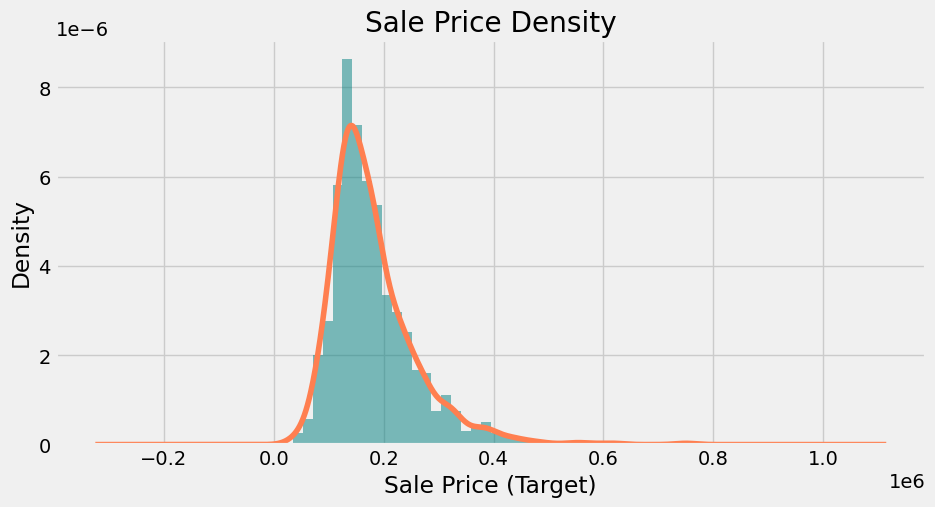

In [15]:
# Plotting distribution for Target Variable (SalePrice)
fig, ax = plt.subplots(figsize=(10,5))

df['SalePrice'].plot(kind='kde',ax=ax, color='coral',)
df['SalePrice'].hist(density=True, ax=ax, color='teal', alpha=0.5, bins=40)  

ax.set_xlabel('Sale Price (Target)')
ax.set_ylabel('Density')
ax.set_title('Sale Price Density')

plt.show()

From this plot, we can observe that our target variable, Sale Price, is normally distributed. This indicates that most houses are priced around a central value, suggesting a similar range of sale prices across the dataset. The normal distribution also implies that there is not a significant amount of extreme variation or outliers in sale prices.

array([[<Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>,
        <Axes: title={'center': 'YearRemodAdd'}>],
       [<Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>,
        <Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>],
       [<Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>,
        <Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>],
       [<Axes: title={'center': 'HalfBath'}>,
        <Axes: title={'center': 'BedroomAbvGr'}>,
        <Axes: title={'center': 'Kit

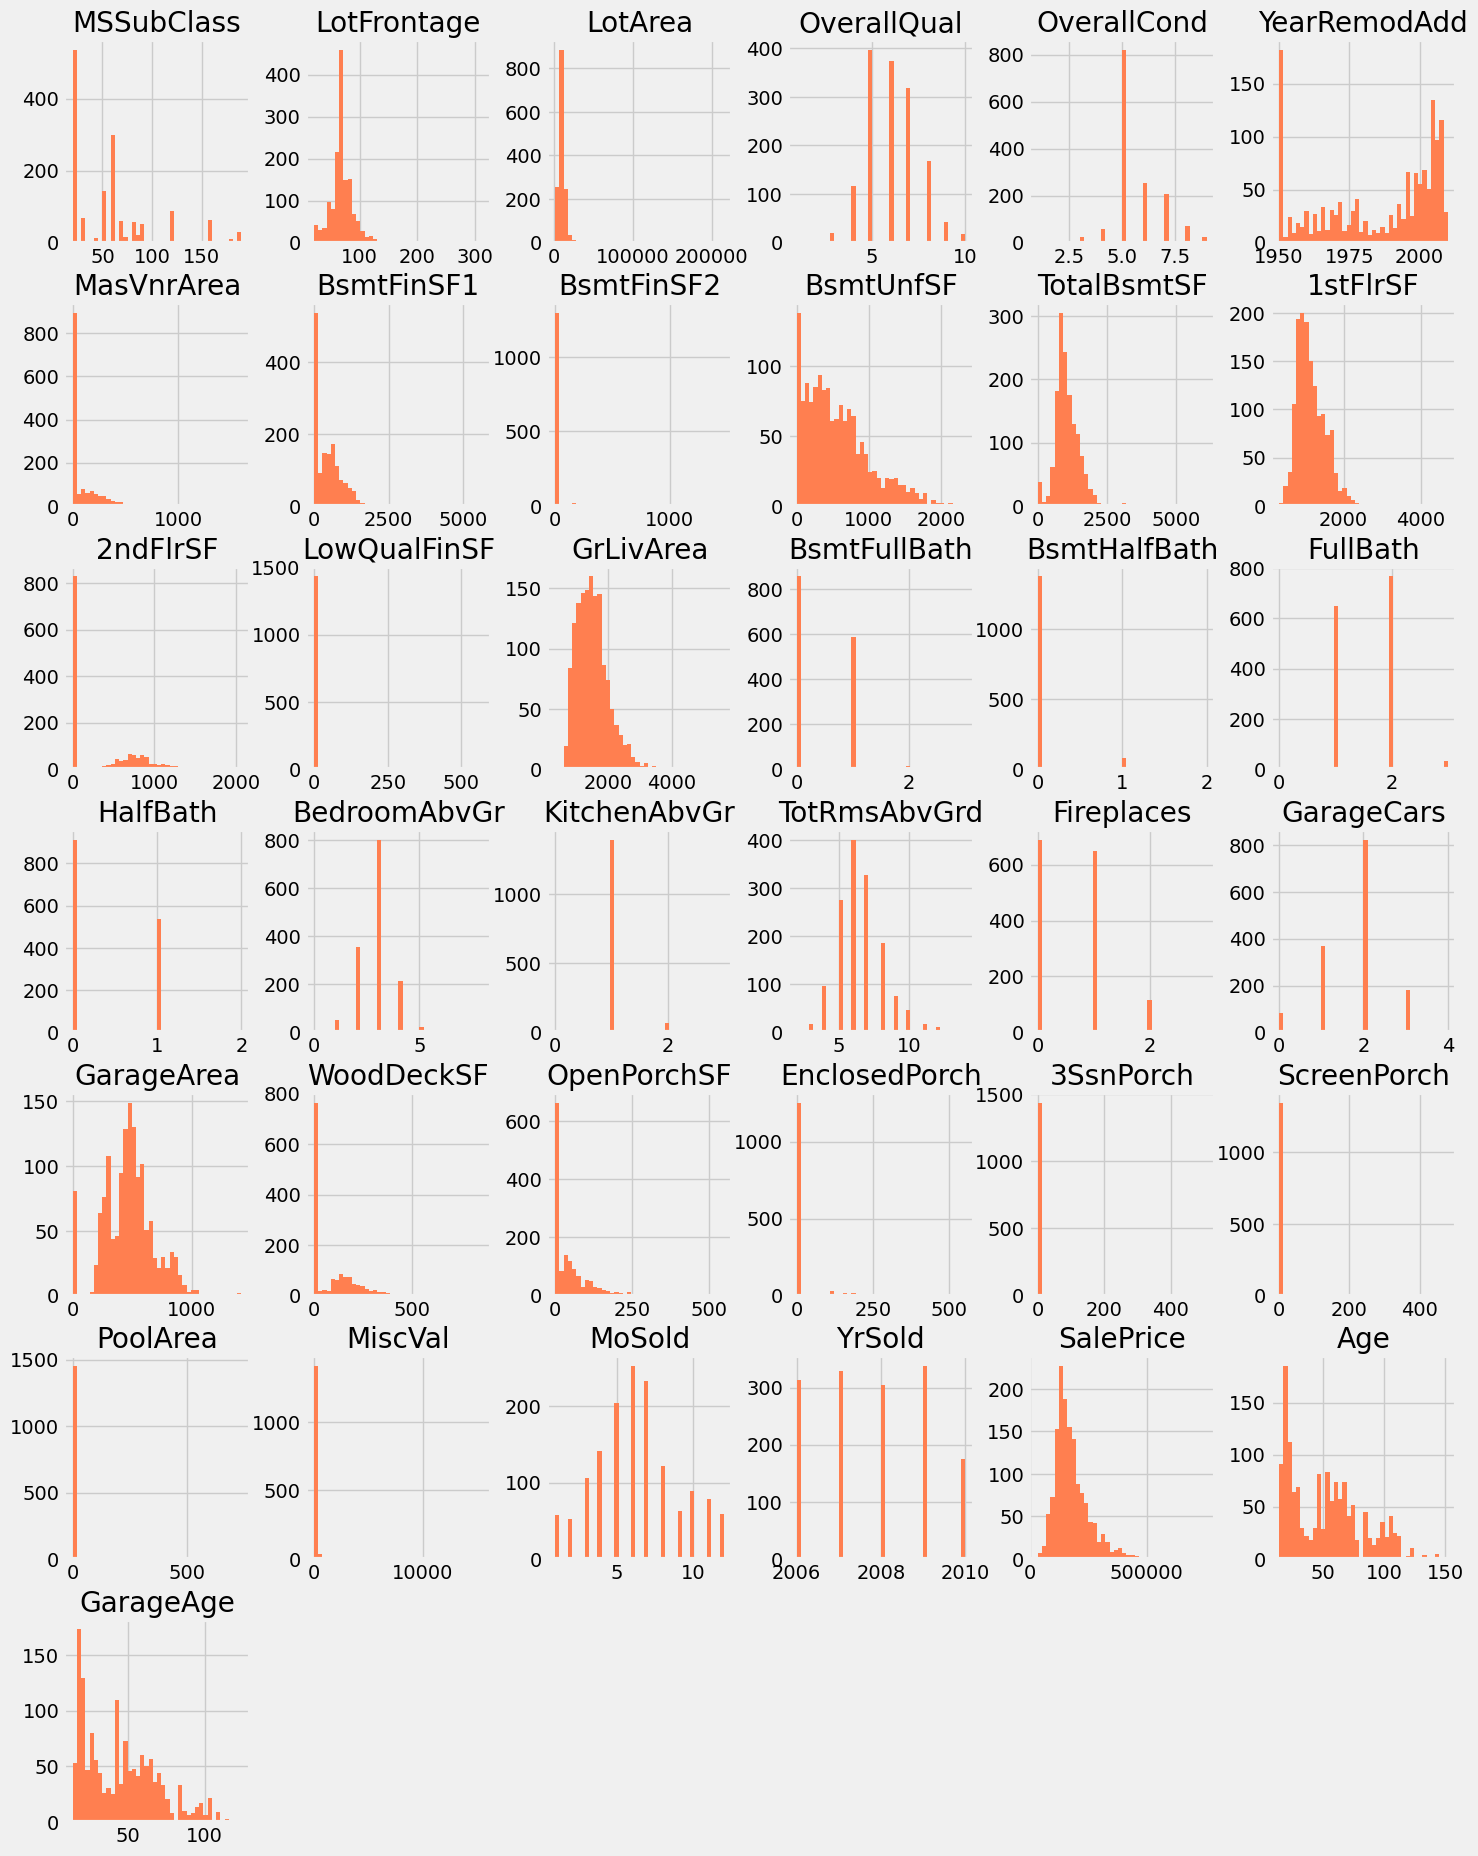

In [16]:
numeric_df = df.select_dtypes(include='number')
numeric_features = numeric_df.columns
numeric_df.hist(figsize=(16, 22), bins=40, color='coral')

From these plots we can see that of the numerical features we have the continous variables indicated by the more complete graphs (SalePrice, Age, GarageAge, GarageArea, etc) and discrete indicated by the sparse graphs (GarageCars, FirePlaces, KitchenAbvGr, etc).

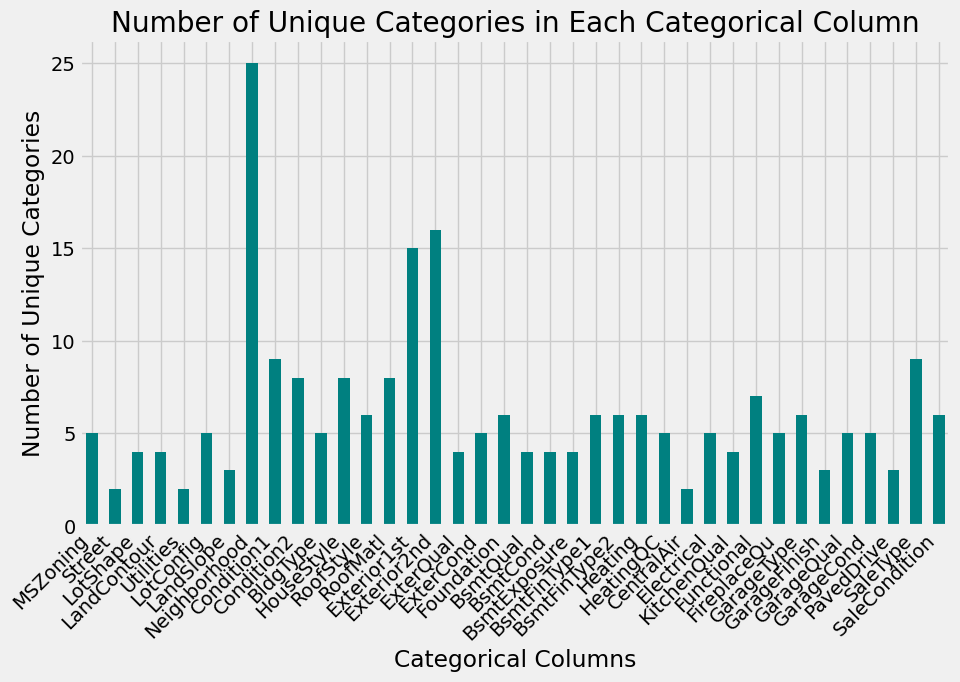

In [17]:
cat_df = df.select_dtypes(include='object')
unique_counts = cat_df.nunique()

plt.figure(figsize=(10, 6))
unique_counts.plot(kind='bar', color='teal')

plt.title('Number of Unique Categories in Each Categorical Column')
plt.xlabel('Categorical Columns')
plt.ylabel('Number of Unique Categories')
plt.xticks(rotation=45, ha='right') 

plt.show()


This plot gives us the cardinality of our categorical features, most are in the 0-5 range however we have some higher ones like Neighborhood.

In [18]:
# cat_df = pd.DataFrame(cat_df['MSZoning'])

## Encoding
Since we are going to use an embedding layer we will be using LabelEncoder. Different encoders can be experiemented with however, this one works easiest.



In [19]:
# Loop through categorical columns and encode them
cat_features = cat_df.columns
encoders = {col: LabelEncoder() for col in cat_features}

for col in cat_features:
    df[col] = encoders[col].fit_transform(df[col])

df[cat_features]

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition
0,3,1,3,3,0,4,0,5,2,2,...,2,6,2,1,1,4,4,2,8,4
1,3,1,3,3,0,2,0,24,1,2,...,3,6,4,1,1,4,4,2,8,4
2,3,1,0,3,0,4,0,5,2,2,...,2,6,4,1,1,4,4,2,8,4
3,3,1,0,3,0,0,0,6,2,2,...,2,6,2,5,2,4,4,2,8,0
4,3,1,0,3,0,2,0,15,2,2,...,2,6,4,1,1,4,4,2,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,3,1,3,3,0,4,0,8,2,2,...,3,6,4,1,1,4,4,2,8,4
1456,3,1,3,3,0,4,0,14,2,2,...,3,2,4,1,2,4,4,2,8,4
1457,3,1,3,3,0,4,0,6,2,2,...,2,6,2,1,1,4,4,2,8,4
1458,3,1,3,3,0,4,0,12,2,2,...,2,6,2,1,2,4,4,2,8,4


## Feature Selection
We will employ a Decision Trees model to evaluate feature importance, which assists in identifying the most influential variables. With the feature importances we can select which features should be selected for our model defined by some threshold. A common threshold is usually above $.01$ however this parameter can be tuned for different results.

In [20]:
# Split data, scale it, fit to model and get important features
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = DecisionTreeRegressor(random_state=42)  

model.fit(X_train, y_train)
importances = model.feature_importances_
feature_names = X.columns

feature_importances = dict(zip(feature_names, importances))

In [21]:
# Filter out variables that have little influence
importance_threshold = 0.001

important_features = {feature: importance for feature, importance in feature_importances.items() if importance >= importance_threshold}

df = df[list(important_features.keys())]

df

,MSSubClass,LotFrontage,LotArea,LandSlope,Neighborhood,OverallQual,OverallCond,YearRemodAdd,MasVnrArea,ExterQual,...,Fireplaces,GarageType,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch,MoSold,Age,GarageAge
0,60,65.0,8450,0,5,7,5,2003,196.0,2,...,0,1,2,548,0,61,0,2,21,21.0
1,20,80.0,9600,0,24,6,8,1976,0.0,3,...,1,1,2,460,298,0,0,5,48,48.0
2,60,68.0,11250,0,5,7,5,2002,162.0,2,...,1,1,2,608,0,42,0,9,23,23.0
3,70,60.0,9550,0,6,7,5,1970,0.0,3,...,1,5,3,642,0,35,0,2,109,26.0
4,60,84.0,14260,0,15,8,5,2000,350.0,2,...,1,1,3,836,192,84,0,12,24,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,60,62.0,7917,0,8,6,5,2000,0.0,3,...,1,1,2,460,0,40,0,8,25,25.0
1456,20,85.0,13175,0,14,6,6,1988,119.0,3,...,2,1,2,500,349,0,0,2,46,46.0
1457,70,66.0,9042,0,6,7,9,2006,0.0,0,...,2,1,1,252,0,60,0,5,83,83.0
1458,20,68.0,9717,0,12,5,6,1996,0.0,3,...,0,1,1,240,366,0,0,4,74,74.0


In [22]:
# Revise Categorical and Numerical features list to reflect filtered df
filtered_cat_features = [cat for cat in cat_features if cat in df.columns]
filtered_numeric_features = [num for num in numeric_features if num in df.columns] 
filtered_features = filtered_cat_features + filtered_numeric_features

## Testing Dataset Preprocessing
- Apply the same preprocessing steps as before

In [23]:
df_test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')
df_test['Age']=datetime.datetime.now().year-df_test['YearBuilt']
df_test['GarageAge'] = datetime.datetime.now().year-df_test['GarageYrBlt']
df_test.drop(['YearBuilt','GarageYrBlt'], axis=1, inplace=True)
df_test = df_test[filtered_features + ['Id']]
df_test

,LandSlope,Neighborhood,ExterQual,BsmtCond,BsmtExposure,BsmtFinType1,CentralAir,KitchenQual,Functional,GarageType,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,ScreenPorch,MoSold,Age,GarageAge,Id
0,Gtl,NAmes,TA,TA,No,Rec,Y,TA,Typ,Attchd,...,0,1.0,730.0,140,0,120,6,63,63.0,1461
1,Gtl,NAmes,TA,TA,No,ALQ,Y,Gd,Typ,Attchd,...,0,1.0,312.0,393,36,0,6,66,66.0,1462
2,Gtl,Gilbert,TA,TA,No,GLQ,Y,TA,Typ,Attchd,...,1,2.0,482.0,212,34,0,3,27,27.0,1463
3,Gtl,Gilbert,TA,TA,No,GLQ,Y,Gd,Typ,Attchd,...,1,2.0,470.0,360,36,0,6,26,26.0,1464
4,Gtl,StoneBr,Gd,TA,No,ALQ,Y,Gd,Typ,Attchd,...,0,2.0,506.0,0,82,144,1,32,32.0,1465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,Gtl,MeadowV,TA,TA,No,Unf,Y,TA,Typ,NaN,...,0,0.0,0.0,0,0,0,6,54,NaN,2915
1455,Gtl,MeadowV,TA,TA,No,Rec,Y,TA,Typ,CarPort,...,0,1.0,286.0,0,24,0,4,54,54.0,2916
1456,Gtl,Mitchel,TA,TA,No,ALQ,Y,TA,Typ,Detchd,...,1,2.0,576.0,474,0,0,9,64,64.0,2917
1457,Gtl,Mitchel,TA,TA,Av,GLQ,Y,TA,Typ,NaN,...,0,0.0,0.0,80,32,0,7,32,NaN,2918


In [24]:
test_cat = df_test.select_dtypes(include='object')
test_numeric = df_test.select_dtypes(include='number')

test_cat_features = test_cat.columns
test_numeric_features = [col for col in test_numeric.columns if col != 'Id']

In [25]:
test_encoders = {col: LabelEncoder() for col in test_cat_features}

for col in test_cat_features:
    df_test[col] = test_encoders[col].fit_transform(df_test[col])

df_test[test_cat_features]

,LandSlope,Neighborhood,ExterQual,BsmtCond,BsmtExposure,BsmtFinType1,CentralAir,KitchenQual,Functional,GarageType
0,0,12,3,3,3,4,1,3,6,1
1,0,12,3,3,3,0,1,2,6,1
2,0,8,3,3,3,2,1,3,6,1
3,0,8,3,3,3,2,1,2,6,1
4,0,22,2,3,3,0,1,2,6,1
...,...,...,...,...,...,...,...,...,...,...
1454,0,10,3,3,3,5,1,3,6,6
1455,0,10,3,3,3,4,1,3,6,4
1456,0,11,3,3,3,0,1,3,6,5
1457,0,11,3,3,0,2,1,3,6,6


In [26]:
for category in test_cat_features:
    df_test[category] = df_test[category].fillna(df_test[category].mode()[0])

for numeric in test_numeric_features:
    df_test[numeric] = df_test[numeric].fillna(df_test[numeric].median())
    
df_test[test_cat_features.tolist() +test_numeric_features].isna().sum()

LandSlope       0
Neighborhood    0
ExterQual       0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
CentralAir      0
KitchenQual     0
Functional      0
GarageType      0
MSSubClass      0
LotFrontage     0
LotArea         0
OverallQual     0
OverallCond     0
YearRemodAdd    0
MasVnrArea      0
BsmtFinSF1      0
BsmtUnfSF       0
TotalBsmtSF     0
1stFlrSF        0
2ndFlrSF        0
GrLivArea       0
TotRmsAbvGrd    0
Fireplaces      0
GarageCars      0
GarageArea      0
WoodDeckSF      0
OpenPorchSF     0
ScreenPorch     0
MoSold          0
Age             0
GarageAge       0
dtype: int64

In [27]:
columns_to_convert = ['TotalBsmtSF', 'BsmtUnfSF', 'BsmtFinSF1', 'GarageArea', 'GarageCars']
df_test[columns_to_convert] = df_test[columns_to_convert].astype('int64')

# Model Building

## Convert dataframes to tensors
- Convert dataframes into numpy arrays 
- Convert numpy arrays into Tensors
    - Create tensors (train, test) for Numerical Columns (float)
    - Create tensors (train, test) for Categorical Cumns (int64)
    - Create tensor for Target Variable (SalePrice)


In [28]:
cat_features_concat = np.stack([df[cat] for cat in filtered_cat_features], 1)
cat_features_concat

array([[ 0,  5,  2, ...,  2,  6,  1],
       [ 0, 24,  3, ...,  3,  6,  1],
       [ 0,  5,  2, ...,  2,  6,  1],
       ...,
       [ 0,  6,  0, ...,  2,  6,  1],
       [ 0, 12,  3, ...,  2,  6,  1],
       [ 0,  7,  2, ...,  3,  6,  1]])

In [29]:
test_cat_features_concat = np.stack([df_test[cat] for cat in test_cat_features], 1)
test_cat_features_concat

array([[ 0, 12,  3, ...,  3,  6,  1],
       [ 0, 12,  3, ...,  2,  6,  1],
       [ 0,  8,  3, ...,  3,  6,  1],
       ...,
       [ 0, 11,  3, ...,  3,  6,  5],
       [ 0, 11,  3, ...,  3,  6,  6],
       [ 1, 11,  3, ...,  3,  6,  1]])

In [30]:
cat_features_tensor = torch.tensor(cat_features_concat, dtype=torch.int64)
cat_features_tensor

tensor([[ 0,  5,  2,  ...,  2,  6,  1],
        [ 0, 24,  3,  ...,  3,  6,  1],
        [ 0,  5,  2,  ...,  2,  6,  1],
        ...,
        [ 0,  6,  0,  ...,  2,  6,  1],
        [ 0, 12,  3,  ...,  2,  6,  1],
        [ 0,  7,  2,  ...,  3,  6,  1]])

In [31]:
test_cat_features_tensor = torch.tensor(test_cat_features_concat, dtype=torch.int64)
test_cat_features_tensor

tensor([[ 0, 12,  3,  ...,  3,  6,  1],
        [ 0, 12,  3,  ...,  2,  6,  1],
        [ 0,  8,  3,  ...,  3,  6,  1],
        ...,
        [ 0, 11,  3,  ...,  3,  6,  5],
        [ 0, 11,  3,  ...,  3,  6,  6],
        [ 1, 11,  3,  ...,  3,  6,  1]])

In [32]:
#numeric_df = pd.DataFrame(numeric_df['MSSubClass'])

In [33]:
numeric_features_concat = np.stack([df[num] for num in filtered_numeric_features], 1)
numeric_features_tensor = torch.tensor(numeric_features_concat, dtype=torch.float)

numeric_features_tensor

tensor([[6.0000e+01, 6.5000e+01, 8.4500e+03,  ..., 2.0000e+00, 2.1000e+01,
         2.1000e+01],
        [2.0000e+01, 8.0000e+01, 9.6000e+03,  ..., 5.0000e+00, 4.8000e+01,
         4.8000e+01],
        [6.0000e+01, 6.8000e+01, 1.1250e+04,  ..., 9.0000e+00, 2.3000e+01,
         2.3000e+01],
        ...,
        [7.0000e+01, 6.6000e+01, 9.0420e+03,  ..., 5.0000e+00, 8.3000e+01,
         8.3000e+01],
        [2.0000e+01, 6.8000e+01, 9.7170e+03,  ..., 4.0000e+00, 7.4000e+01,
         7.4000e+01],
        [2.0000e+01, 7.5000e+01, 9.9370e+03,  ..., 6.0000e+00, 5.9000e+01,
         5.9000e+01]])

In [34]:
test_numeric_features_concat = np.stack([df_test[num] for num in test_numeric_features], 1)
test_numeric_features_tensor = torch.tensor(test_numeric_features_concat, dtype=torch.float)

test_numeric_features_tensor

tensor([[2.0000e+01, 8.0000e+01, 1.1622e+04,  ..., 6.0000e+00, 6.3000e+01,
         6.3000e+01],
        [2.0000e+01, 8.1000e+01, 1.4267e+04,  ..., 6.0000e+00, 6.6000e+01,
         6.6000e+01],
        [6.0000e+01, 7.4000e+01, 1.3830e+04,  ..., 3.0000e+00, 2.7000e+01,
         2.7000e+01],
        ...,
        [2.0000e+01, 1.6000e+02, 2.0000e+04,  ..., 9.0000e+00, 6.4000e+01,
         6.4000e+01],
        [8.5000e+01, 6.2000e+01, 1.0441e+04,  ..., 7.0000e+00, 3.2000e+01,
         4.5000e+01],
        [6.0000e+01, 7.4000e+01, 9.6270e+03,  ..., 1.1000e+01, 3.1000e+01,
         3.1000e+01]])

In [35]:
y = torch.tensor(y.values, dtype=torch.float).reshape(-1, 1)
y

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [36]:
print(f'Categorical Features Shape: {cat_features_tensor.shape}\nNumerical Features Shape: {numeric_features_tensor.shape}\nTarget Shape: {y.shape}')
print(f'Categorical Test Features Shape: {test_cat_features_tensor.shape}\nTest Numerical Features Shape: {test_numeric_features_tensor.shape}')

Categorical Features Shape: torch.Size([1460, 10])
Numerical Features Shape: torch.Size([1460, 23])
Target Shape: torch.Size([1460, 1])
Categorical Test Features Shape: torch.Size([1459, 10])
Test Numerical Features Shape: torch.Size([1459, 23])


## Embedding Sizes Creation
Since the train and test columns result in varying amount of unique values we will need to get the embedding sizes for both the train and test. This will change how we compute the final embeddings.

In [37]:
t_embedding_sizes = [len(df_test[col].unique()) for col in df_test[test_cat_features]]
print(t_embedding_sizes)

[3, 25, 4, 5, 5, 7, 2, 5, 8, 7]


In [38]:
embedding_sizes = [len(df[col].unique()) for col in df[filtered_cat_features]]
print(embedding_sizes)

[3, 25, 4, 4, 4, 6, 2, 4, 7, 6]


Here we are taking the max between the two different embeddings to ensure we don't have shape issues when training or predicting.

In [39]:
embedding_dimensions = [(max(size, t_size), min(50, (max(size, t_size)+1) // 2)) for size, t_size in zip(embedding_sizes, t_embedding_sizes)]
embedding_dimensions

[(3, 2),
 (25, 13),
 (4, 2),
 (5, 3),
 (5, 3),
 (7, 4),
 (2, 1),
 (5, 3),
 (8, 4),
 (7, 4)]

## Defining the Model

### Initialization

In the initialization phase we are defining two types of layers
- **Embedding Layer**
    - We create a layer for each embedding dimension defined earlier.
    - Define Dropout Layer for the embeddings 
    - Define Batch Normalization layer for embeddings 

- **Linear Layers**
    - We create a series of layers dependant on the `layers` passed
    - For each layers we define a fully-connected Linear Layer accompanied by ReLU activation function
    - Define Dropout layer for current Linear Layer
    - Define Batch Normalization for current Linear Layer
    
### Forward Passes

- For the forward pass we give the model the categorical and continous features for that batch. The model first calculates the embeddings based on the categorical features and embedding layers defined earlier. The continous features are then passed into the Batch Normalization to Standardize them before being concatenated with the embedded categorical features. The concatenated batch is then sent through the series of Fully-Connected Linear Layers.

In [40]:
class RegressionModel(nn.Module):
    def __init__(self, embedding_dimensions, num_continous, out_size, layers, dropout_rate=0.4):
        super().__init__()
        self.embeddings = nn.ModuleList([nn.Embedding(input_dim,output_dim) for input_dim,output_dim in embedding_dimensions])
        self.embeddings_dropout = nn.Dropout(dropout_rate)
        self.bn_continous = nn.BatchNorm1d(num_continous)
        
        layers_l = []
        num_embeddings = sum((output for _, output in embedding_dimensions))
        total_in = num_embeddings + num_continous
        
        for layer in layers:
            layers_l.append(nn.Linear(total_in,layer)) 
            layers_l.append(nn.ReLU(inplace=True))
            layers_l.append(nn.BatchNorm1d(layer))
            layers_l.append(nn.Dropout(dropout_rate))
            total_in = layer
            
        layers_l.append(nn.Linear(layers[-1],out_size))
        self.layers = nn.Sequential(*layers_l)
            
    def forward(self, categorical, continous):
        embeddings = []
        for i,e in enumerate(self.embeddings):
            embeddings.append(e(categorical[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.embeddings_dropout(x)
        
        cont = self.bn_continous(continous)
        x = torch.cat([x, cont], 1)
        x = self.layers(x)
        return x


In [41]:
model = RegressionModel(embedding_dimensions, len(filtered_numeric_features), 1, [100,50], 0.4)

In [42]:
model

RegressionModel(
  (embeddings): ModuleList(
    (0): Embedding(3, 2)
    (1): Embedding(25, 13)
    (2): Embedding(4, 2)
    (3-4): 2 x Embedding(5, 3)
    (5): Embedding(7, 4)
    (6): Embedding(2, 1)
    (7): Embedding(5, 3)
    (8): Embedding(8, 4)
    (9): Embedding(7, 4)
  )
  (embeddings_dropout): Dropout(p=0.4, inplace=False)
  (bn_continous): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=62, out_features=100, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=100, out_features=50, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=50, out_features=1, bias=True)
  )
)

This is a nice representation of our model, we can see the embedding layers defined by the dimensions we created earlier. Then we can see the series of linear layers we defined.

In [43]:
# Define Optimizer (Adam) and Loss function (MSE)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.MSELoss()

In [44]:
# Split data into train and test
batch_size=1200
test_size=int(batch_size*0.15)
train_categorical=cat_features_tensor[:batch_size-test_size]
test_categorical=cat_features_tensor[batch_size-test_size:batch_size]
train_cont=numeric_features_tensor[:batch_size-test_size]
test_cont=numeric_features_tensor[batch_size-test_size:batch_size]
y_train=y[:batch_size-test_size]
y_test=y[batch_size-test_size:batch_size]

In [45]:
len(train_categorical),len(test_categorical),len(train_cont),len(test_cont),len(y_train),len(y_test)

(1020, 180, 1020, 180, 1020, 180)

### Model Training

Here we train our model over a series of epochs. Early stopping is in-place however, this model takes a large number of epochs to converge (2500-3000 with lr=0.001). This can be played around with however I'd reccomend the model see at least 2500 epochs. 

In [46]:
epochs = 500

dataset = TensorDataset(train_categorical, train_cont, y_train)
test_dataset = TensorDataset(test_categorical, test_cont, y_test)

validation_size = int(len(dataset) * 0.2)  
train_size = len(dataset) - validation_size
train_dataset, val_dataset = random_split(dataset, [train_size, validation_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

best_val_loss = float('inf')  
epochs_no_improve = 0
early_stopping_patience = 5000

train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_loss_epoch = 0
    for batch in train_loader:
        cat, cont, y = batch
        
        optimizer.zero_grad()
        y_pred = model(cat, cont)
        loss = torch.sqrt(loss_function(y_pred, y))
        loss.backward()
        optimizer.step()
        train_loss_epoch += loss.item()
    
    train_loss_epoch /= len(train_loader)
    train_losses.append(train_loss_epoch)
    
    model.eval()
    val_loss_epoch = 0
    with torch.no_grad():
        for val_batch in val_loader:
            val_cat, val_cont, val_y = val_batch
            val_y_pred = model(val_cat, val_cont)
            val_loss_epoch += torch.sqrt(loss_function(val_y_pred, val_y)).item()
    
    val_loss_epoch /= len(val_loader)
    val_losses.append(val_loss_epoch)
    
    if val_loss_epoch < best_val_loss:
        best_val_loss = val_loss_epoch
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= early_stopping_patience:
            print(f"Early stopping triggered. Stopping training at epoch {epoch+1}")
            break


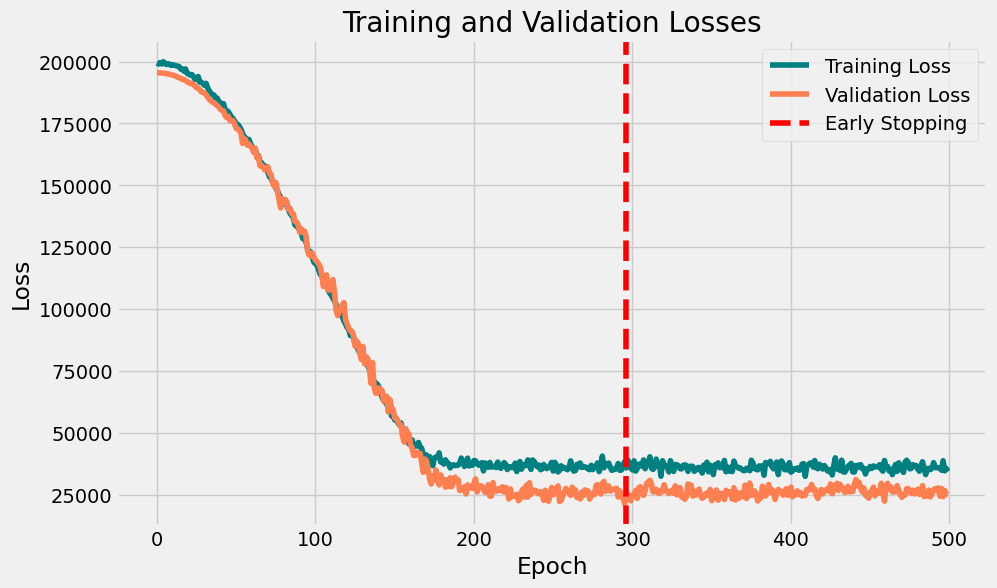

In [47]:
# Plot our Training and Validation while Training
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', color='teal')
plt.plot(val_losses, label='Validation Loss', color='coral')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)

early_stopping_epoch = len(train_losses) - epochs_no_improve
plt.axvline(x=early_stopping_epoch, color='r', linestyle='--', label='Early Stopping')
plt.legend()
plt.show()

This graph shows that we slowly decreased both losses over a lot of epochs. Usually the graph slows down at around 2500 which will be displayed here. If the epochs is set low this graph will usually have a lot of variance which indicates our model has not converged yet.

In [48]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # Shuffle isn't needed for evaluation

model.eval()

test_loss = 0
all_y_pred = []
all_y_true = []

with torch.no_grad():
    for batch in test_loader:
        cat, cont, y_true = batch
        y_pred = model(cat, cont)

        loss = torch.sqrt(loss_function(y_pred, y_true))
        test_loss += loss.item()

        all_y_pred.append(y_pred)
        all_y_true.append(y_true)

all_y_pred = torch.cat(all_y_pred, dim=0)
all_y_true = torch.cat(all_y_true, dim=0)

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss}")

mse = mean_squared_error(all_y_true.numpy(), all_y_pred.numpy())
rmse = np.sqrt(mse)
r2 = r2_score(all_y_true.numpy(), all_y_pred.numpy())

print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared: {r2}")

Test Loss: 24253.259765625
Root Mean Squared Error: 24544.30078125
R-squared: 0.9208115323196502


In [49]:
submit_dataset = TensorDataset(test_cat_features_tensor, test_numeric_features_tensor)
submit_loader = DataLoader(submit_dataset, batch_size=32, shuffle=False)

In [50]:
model.eval()

test_loss = 0
all_y_pred = []

with torch.no_grad():
    for batch in submit_loader:
        cat, cont = batch
        y_pred = model(cat, cont)

        all_y_pred.append(y_pred)
        
all_y_pred = torch.cat(all_y_pred).numpy()

df_submit = pd.DataFrame({
    'Id': df_test['Id'],
    'SalePrice': all_y_pred.flatten()  
})

df_submit.to_csv('submission.csv', index=False)